In [35]:
import pandas as pd
import keras_ocr
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import spacy
import re
import OMR_yes_no 
from spacy.pipeline import EntityRuler
import csv




2. OCR Application (by using easyOCR)


In [36]:
#reader for easyOCR 
reader = easyocr.Reader(['en'])
#nlp for spacy NER
nlp = spacy.load("en_core_web_trf")


1. Image Preprocessing

In [37]:
img = '/Users/qadirrun/Documents/ETL/omr/custom_declaration_1.png'
result = reader.readtext(img)
img_df = pd.DataFrame(result, columns = ['bbox', 'text', 'conf'])
img_id = img.split('/')[-1].split('.')[0]

3. Text Data Cleaning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


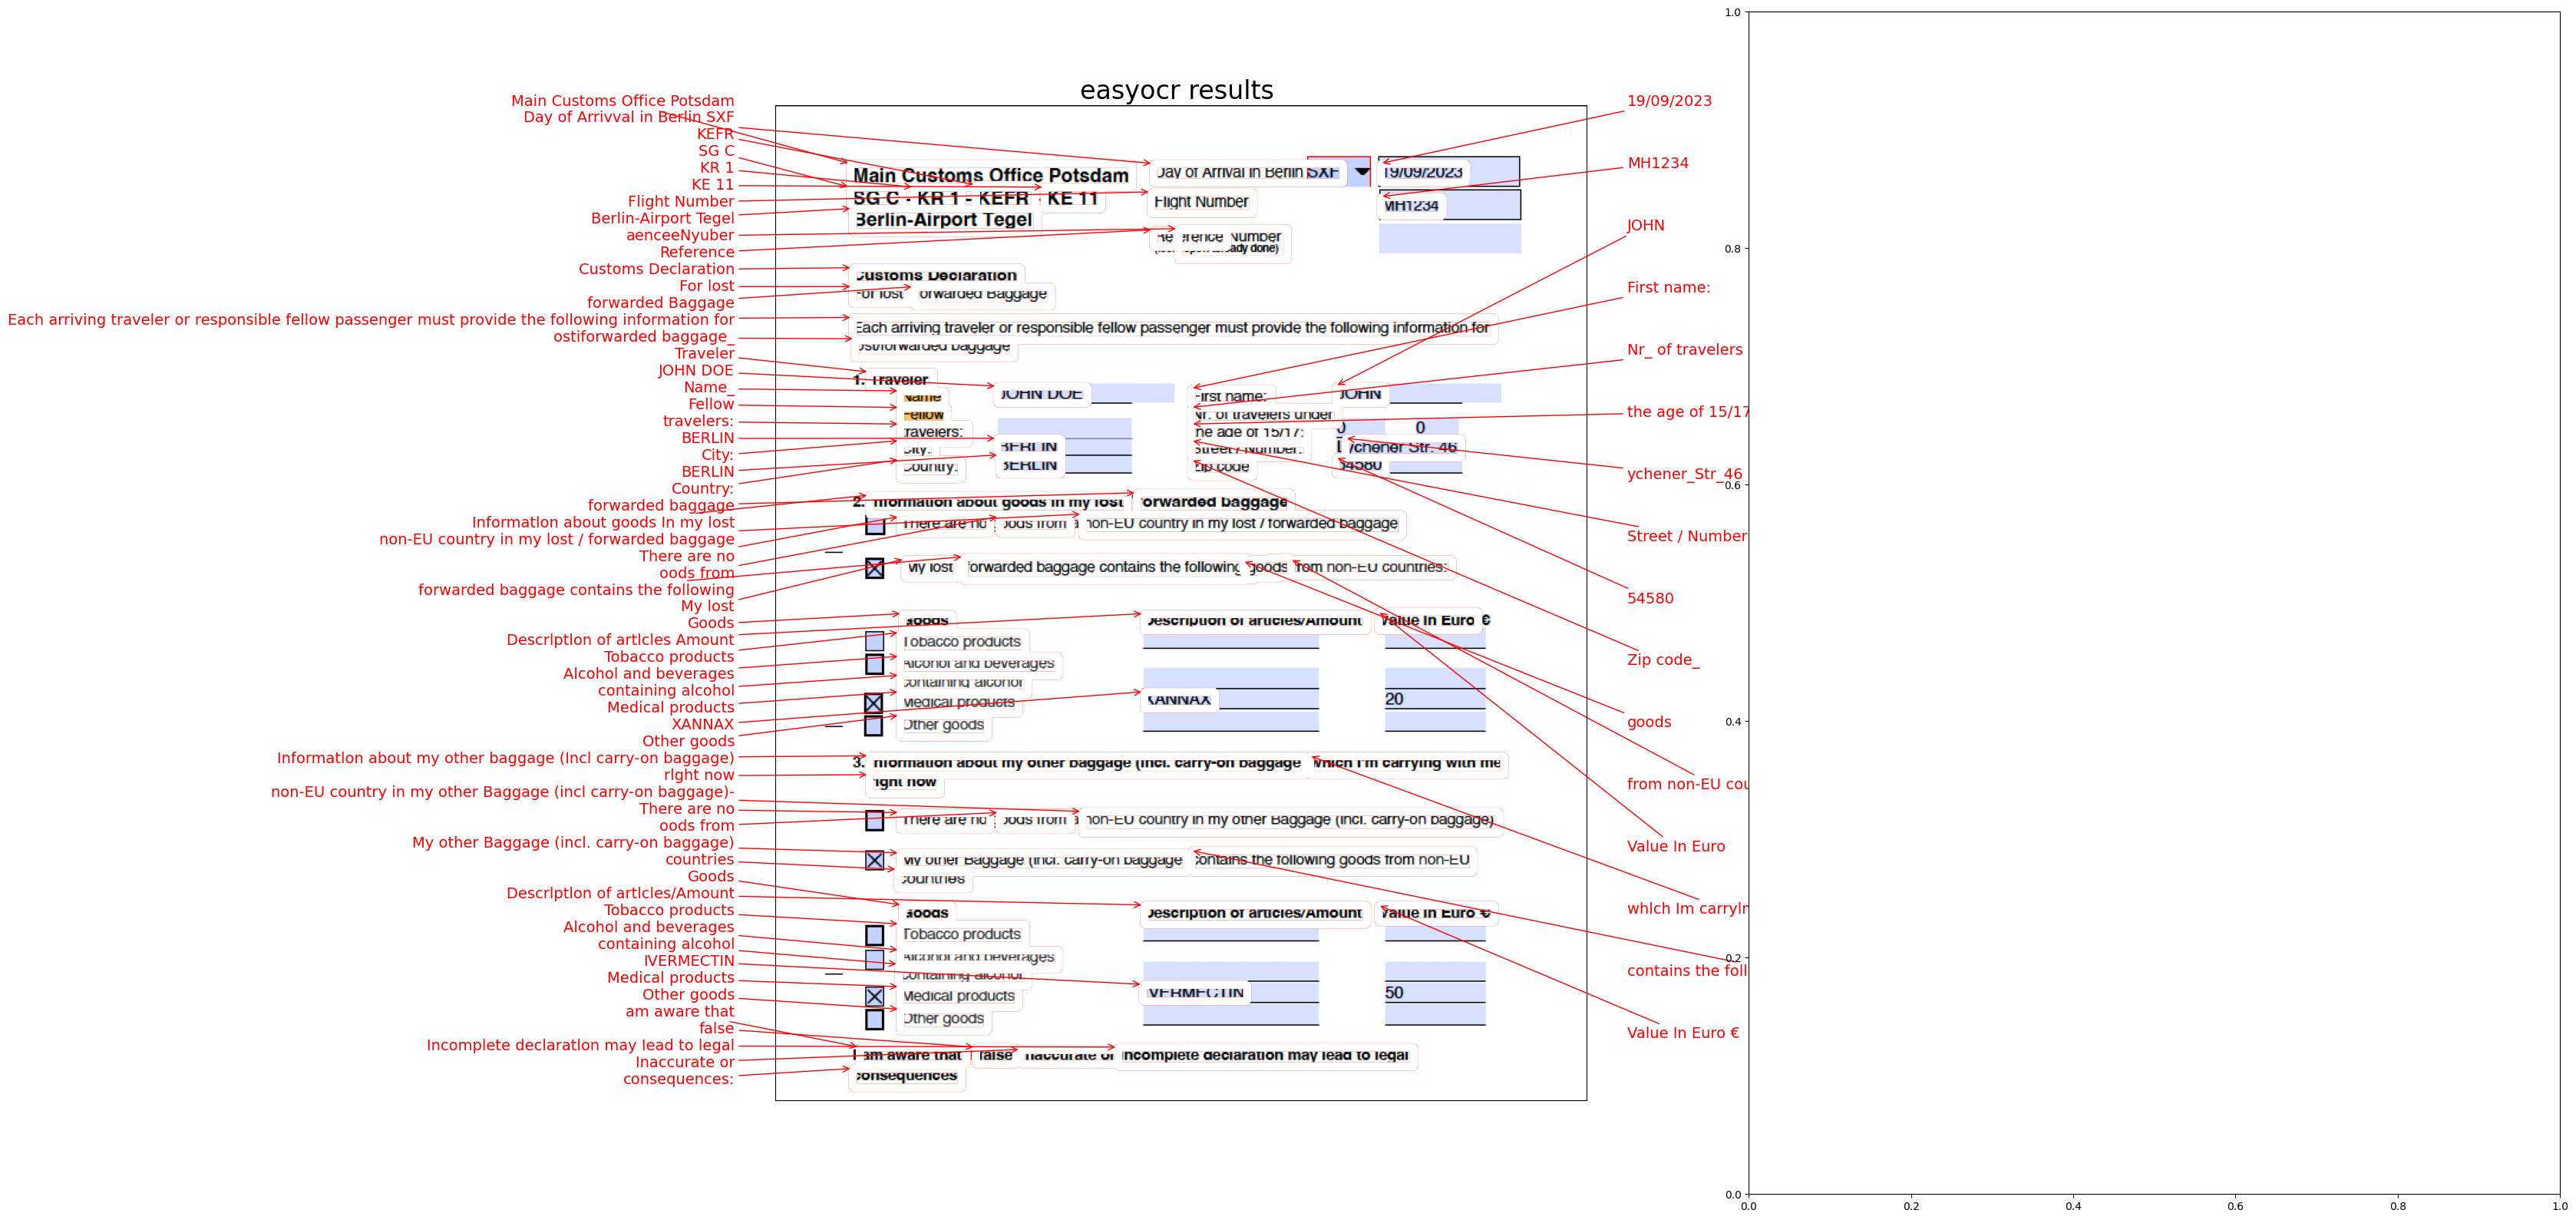

In [38]:
confidence_threshold = 0.2

filtered_results = img_df[img_df['conf'] >= confidence_threshold]
# Prepare the filtered results for visualization
filtered_easy_results = filtered_results[['text', 'bbox']].values.tolist()
filtered_easy_results = [(x[0], np.array(x[1])) for x in filtered_easy_results]

# Visualize the filtered results using Keras-OCR
fig, axs = plt.subplots(1, 2, figsize=(30, 20))
keras_ocr.tools.drawAnnotations(plt.imread(img), filtered_easy_results, ax=axs[0])
axs[0].set_title('easyocr results ', fontsize=24)

plt.show()

In [39]:
result_list = img_df.apply(lambda row: [row['text'], row['bbox']], axis=1).tolist()

text_only = [item[0] for item in result_list]
text_string = ' '.join(text_only)
text_string

'Main Customs Office Potsdam Day of Arrivval in Berlin SXF 19/09/2023 SG C KR 1 KEFR KE 11 Flight Number MH1234 Berlin-Airport Tegel Reference aenceeNyuber Customs Declaration For lost forwarded Baggage Each arriving traveler or responsible fellow passenger must provide the following information for ostiforwarded baggage_ Traveler Name_ JOHN DOE First name: JOHN Fellow Nr_ of travelers under travelers: the age of 15/17: City: BERLIN Street / Number: ychener_Str_46 Country: BERLIN Zip code_ 54580 Informatlon about goods In my lost forwarded baggage There are no oods from non-EU country in my lost / forwarded baggage My lost forwarded baggage contains the following from non-EU countries: Goods Descrlptlon of artlcles Amount Value In Euro Tobacco products Alcohol and beverages containing alcohol Medical products XANNAX Other goods Informatlon about my other baggage (Incl carry-on baggage) whlch Im carrylng wlth me rlght now There are no oods from non-EU country in my other Baggage (incl c

4.Named Entity Recognition (NER) or key information extraction + Mapping

In [40]:
#using 
doc = nlp(text_string)
text_string

'Main Customs Office Potsdam Day of Arrivval in Berlin SXF 19/09/2023 SG C KR 1 KEFR KE 11 Flight Number MH1234 Berlin-Airport Tegel Reference aenceeNyuber Customs Declaration For lost forwarded Baggage Each arriving traveler or responsible fellow passenger must provide the following information for ostiforwarded baggage_ Traveler Name_ JOHN DOE First name: JOHN Fellow Nr_ of travelers under travelers: the age of 15/17: City: BERLIN Street / Number: ychener_Str_46 Country: BERLIN Zip code_ 54580 Informatlon about goods In my lost forwarded baggage There are no oods from non-EU country in my lost / forwarded baggage My lost forwarded baggage contains the following from non-EU countries: Goods Descrlptlon of artlcles Amount Value In Euro Tobacco products Alcohol and beverages containing alcohol Medical products XANNAX Other goods Informatlon about my other baggage (Incl carry-on baggage) whlch Im carrylng wlth me rlght now There are no oods from non-EU country in my other Baggage (incl c

In [41]:
#look what iniside the extracted string on OCR
for ent in doc.ents:
    print(ent.text, ent.label_)

Main Customs Office ORG
Berlin GPE
19/09/2023 DATE
MH1234 PRODUCT
Berlin-Airport FAC
JOHN DOE PERSON
First ORDINAL
JOHN Fellow PERSON
the age of 15/17 DATE
BERLIN GPE
non-EU NORP
non-EU NORP
non-EU NORP
non-EU NORP


In [42]:

flight_number_pattern = r'\b[A-Z]{2}\d{3,4}\b'
flight_matches = re.findall(flight_number_pattern, text_string)
flight_numbers_string = ', '.join(flight_matches)

date_format = "\d{1,2}/\d{1,2}/\d{3,4}"
date = re.findall(date_format, text_string)
date_match = ', '.join(date)

if "entity_ruler" not in nlp.pipe_names:
    # Create an entity ruler for adding patterns to the NER model
    ruler = nlp.add_pipe("entity_ruler")

    # Define patterns with the "FLIGHT_NUMBER" label using flight_numbers_string
    patterns = [
        {"label": "FLIGHT_NUMBER", "pattern": flight_numbers_string},
        {"label": "DATE", "pattern": date_match}
    ]
    # Add the patterns to the entity ruler
    ruler.add_patterns(patterns)




In [43]:
#reassign the doc
doc =nlp(text_string)


In [44]:
#look for entity inside the forms
for ent in doc.ents:
    print(ent.text, ent.label_)

Main Customs Office ORG
Berlin GPE
19/09/2023 DATE
MH1234 PRODUCT
Berlin-Airport FAC
JOHN DOE PERSON
First ORDINAL
JOHN Fellow PERSON
the age of 15/17 DATE
BERLIN GPE
non-EU NORP
non-EU NORP
non-EU NORP
non-EU NORP


In [45]:
#for the section of goods for both form
sentences_list = list(doc.sents)
if len(sentences_list[4].text) > 100:
    text1 = sentences_list[4].text
else:
    text1 = sentences_list[5].text

specific_sentence_text = text1



In [46]:

doc2 = nlp(specific_sentence_text)
text_as_string = str(doc2)
# text_as_string

In [47]:
def split_text_into_sentences(text):
    # Split the text into sentences based on the pattern
    sentences = re.split(r'([A-Z])', text)
    new_sentences = [sentences[0]]
    for i in range(1, len(sentences) - 1, 2):
        if sentences[i + 1].islower():
            new_sentences.append(sentences[i] + sentences[i + 1])
        else:
            new_sentences[-1] += sentences[i] + sentences[i + 1]
    
    return new_sentences

sentences = split_text_into_sentences(text_as_string)
# sentences


In [48]:

item=[]
for sentence in sentences:
    item.append(sentence)    
# item

In [49]:
#function for repeating uppercase word (goods description) for form 1
def has_uppercase_words(text):
    for word in text.split():
        if sum(1 for char in word if char.isupper()) > 1:
            return True
    return False


In [50]:
#this is for good description
indices_with_uppercase = []

# Iterate through the array and check for uppercase words
for i, sentence in enumerate(sentences):
    if has_uppercase_words(sentence):
        indices_with_uppercase.append(sentence)


In [51]:
#get the first value of the entity found
first_name = None
first_traveling_date = None
first_flight_number = None

for ent in doc.ents:
    if first_name is None and ent.label_ == "PERSON":
        first_name = ent.text
    elif first_traveling_date is None and ent.label_ == "DATE":
        first_traveling_date = ent.text
    elif first_flight_number is None and (ent.label_ == "PRODUCT" or ent.label_ == "FLIGHT_NUMBER"):
        first_flight_number = ent.text

In [54]:
#form 1 & 2 diffrence is yes/no and tick box
if "yes" in text_string.lower() and "no" in text_string.lower():
    #for form 2, the yes and no is done by using Optical Mark Recognition
    myIndex = OMR_yes_no.process_image_and_get_indices(img)
    print("Name:", first_name)
    print("Traveling Date:", first_traveling_date)
    print("Flight Number(s):", first_flight_number)
    print("Controlled Item(s) Indicator (yes:0,no:1):", myIndex)
else:
    controlled_item_indicator = ', '.join(map(str, indices_with_uppercase))

    print("Name:", first_name)
    print("Traveling Date:", first_traveling_date)
    print("Flight Number(s):", first_flight_number)
    print("Controlled Item(s) Indicator:", controlled_item_indicator)




Name: JOHN DOE
Traveling Date: 19/09/2023
Flight Number(s): MH1234
Controlled Item(s) Indicator: Medical products XANNAX , Medical products IVERMECTIN 


5. Data Storage (CSV)

In [53]:
data = []
if "yes" in text_string.lower() and "no" in text_string.lower():
    # Process data using OMR
    myIndex = OMR_yes_no.process_image_and_get_indices(img)
    controlled_item_indicator = myIndex
else:
    controlled_item_indicator = indices_with_uppercase

# Define the data to be stored in the CSV
data.append({
    "Name": first_name,
    "Traveling Date": first_traveling_date,
    "Flight Number(s)": first_flight_number,
    "Controlled Item(s) Indicator": controlled_item_indicator
})

# Specify the CSV file path
csv_file_path = "output_data.csv"

with open(csv_file_path, mode='w', newline='') as file:
    fieldnames = ["Name", "Traveling Date", "Flight Number(s)", "Controlled Item(s) Indicator"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()  # Write the header row
    for row in data:
        writer.writerow(row)

print(f"Data has been stored in {csv_file_path}")

Data has been stored in output_data.csv
